In [72]:
from data import Data
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from utils import timestamp
import math

In [122]:
seed = 40 # random seed to guarantee reproducibility of results
OPT_K = 50 # number of K in Kmeans clustering
BREED_LEN = 5 # number of perspective patterns to explore during BO stage

In [6]:
dt = Data(seed)

Loading dataset from file... This may take a few minutes...
Loaded dataset in 78 seconds


In [7]:
df, random_cells, random_results = dt.query_batch()

  0%|          | 2/1000 [00:00<00:55, 17.93it/s]

I01DT: Collecting unique architectures


  2%|▎         | 25/1000 [00:00<01:14, 13.01it/s]

I02DT: Evaluating unique architectures


100%|██████████| 1000/1000 [00:03<00:00, 264.04it/s]


I03DT: Saving log df of observations
I04DT: Plotting observed data


In [ ]:
df

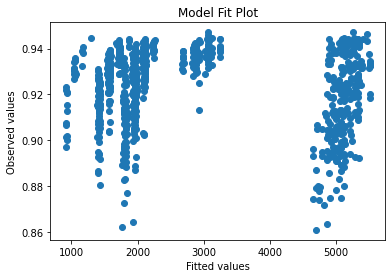

In [45]:
fig, ax = plt.subplots()
ax.scatter(df['training_time'], df['validation_accuracy'])
ax.set_title('Model Fit Plot')
ax.set_ylabel('Validation accuracy')
ax.set_xlabel('Training time');

In [ ]:
# similarities = np.zeros((df.shape[0], df.shape[0]))

# i = 0
# for h1 in tqdm(df.index):
#     j = 0
#     for h2 in df.index:
#         if h1 != h2:
#             matrix1 = np.asarray(random_cells[str(h1)]['matrix'])
#             matrix2 = np.asarray(random_cells[str(h2)]['matrix'])
#             similarities[i][j] = np.count_nonzero(
#                 (matrix1 + matrix2) == 2 # to filter out lower triangular similarity
#             )
#         j += 1
#     i += 1

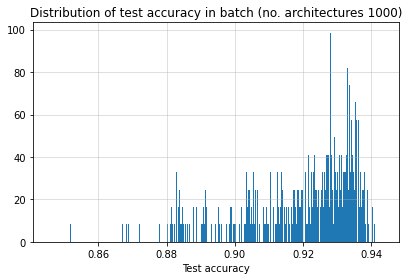

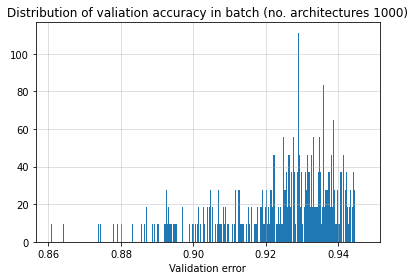

In [11]:
dt.plot_data(df)

100%|██████████| 299/299 [05:18<00:00,  1.07s/it]


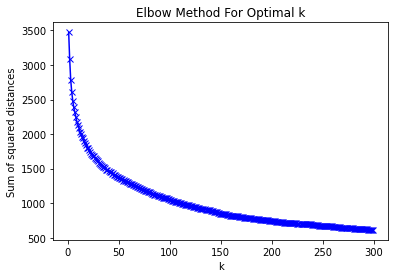

In [24]:
cell_structures = [np.asarray(random_cells[str(h)]['matrix']).reshape(-1) for h in df.index]
sum_of_squared_distances = []
K = range(1,300)
cell_structures
for k in tqdm(K):
    km = KMeans(n_clusters=k, random_state = seed)
    km = km.fit(cell_structures)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
t = timestamp()
plt.savefig('figures/sum_of_squares' + str(t) + '.pdf', dpi=600)
plt.show()

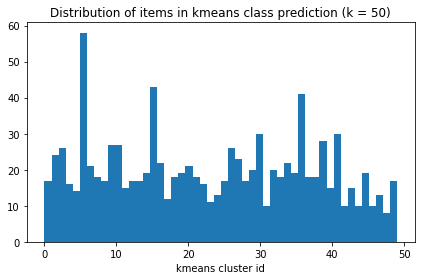

In [33]:
# Below default OPT_K is 50; This is not optimal, but since we are limited with budget of initial sample
# we are good with having this number this small - for more details, refer to thesis
# This value should be treated as a hyperparameter
km = KMeans(n_clusters=OPT_K, random_state = seed)
km = km.fit(cell_structures)
predicted_k = km.predict(cell_structures)

t = timestamp()
plt.figure()
plt.title('Distribution of items in kmeans class prediction (k = {})'.format(opt_k))
plt.hist(predicted_k, bins=OPT_K)
plt.xlabel('kmeans cluster id')
#plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.savefig('figures/kmeans_class_dist' + str(t) + '.pdf', dpi=600)
plt.show()

In [34]:
df['class'] = predicted_k

In [98]:
def rank_column(x):
    return [math.floor(i * 10 / OPT_K) for i in stats.rankdata(x, "average")]

In [125]:
by_class = df\
    .groupby(['class'])['validation_accuracy', 'test_accuracy', 'training_time']\
    .agg(['mean', 'std'])

by_class['validation_accuracy_rank'] = rank_column(by_class['validation_accuracy']['mean'])
by_class['training_time_rank'] = rank_column(by_class['training_time']['mean'])

by_class = by_class.sort_values(['validation_accuracy_rank', 'training_time_rank'], ascending=[False, True])
breed = by_class[by_class.training_time_rank.le(3)].head(BREED_LEN).index.to_numpy()
# We are not interested in high computation time
# Thats why we filter out training_time_rank > 3
breed

/Users/volodymyr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


array([ 7, 23, 47,  8, 37])

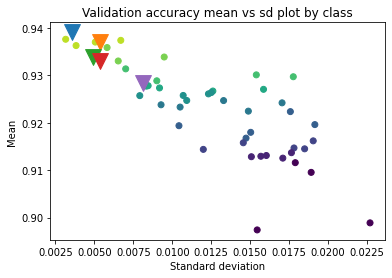

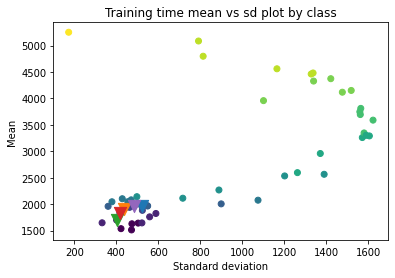

In [126]:
fig, ax = plt.subplots()
ax.scatter(by_class['validation_accuracy']['std'],
           by_class['validation_accuracy']['mean'],
           c=by_class['validation_accuracy_rank']
)
for b in breed:
    ax.scatter(
        by_class.loc[b]['validation_accuracy']['std'],
        by_class.loc[b]['validation_accuracy']['mean'],
        marker = "v",
        s = 250
    )
ax.set_title('Validation accuracy mean vs sd plot by class')
ax.set_ylabel('Mean')
ax.set_xlabel('Standard deviation');
plt.savefig('figures/kmeans_validation_mean_sd' + str(t) + '.pdf', dpi=600)
plt.show()

fig, ax = plt.subplots()
ax.scatter(by_class['training_time']['std'], by_class['training_time']['mean'], c=by_class['training_time_rank'])
for b in breed:
    ax.scatter(
        by_class.loc[b]['training_time']['std'],
        by_class.loc[b]['training_time']['mean'],
        marker = "v",
        s = 150
    )
ax.set_title('Training time mean vs sd plot by class')
ax.set_ylabel('Mean')
ax.set_xlabel('Standard deviation');
plt.savefig('figures/kmeans_training_time_mean_sd' + str(t) + '.pdf', dpi=600)
plt.show()

fig, ax = plt.subplots()
ax.scatter(by_class['training_time']['mean'], by_class['validation_accuracy']['mean'])
for b in breed:
    ax.scatter(
        by_class.loc[b]['training_time']['mean'],
        by_class.loc[b]['validation_accuracy']['mean'],
        marker = "v",
        s = 150
    )
ax.set_title('Training time mean vs Validation accuracy mean by class')
ax.set_ylabel('Mean validation accuracy')
ax.set_xlabel('Mean training time');
plt.savefig('figures/kmeans_training_time_mean_sd' + str(t) + '.pdf', dpi=600)
plt.show()

NameError: name 'matrix2' is not defined

In [ ]:
matrix1 + matrix2

In [ ]:
(matrix1 + matrix2) == 2

In [ ]:
np.count_nonzero((matrix1 + matrix2) == 2)